<h1>구매 행동 기반 세분화</h1>

In [1]:
import pandas as pd
import numpy as np

# 데이터 로드
onlinesales = pd.read_csv('data/Onlinesales_info.csv')
customer_info = pd.read_csv('data/Customer_info.csv')

# 고객별 구매 데이터
customer_purchase = onlinesales.groupby('고객ID').agg(
    구매빈도=('거래ID', 'nunique'),  # 거래 횟수
    평균구매금액=('평균금액', 'mean'),  # 평균 구매 금액
    총구매금액=('평균금액', 'sum')  # 총 구매 금액
).reset_index()

# 각 고객이 주로 구매하는 카테고리
top_categories = onlinesales.groupby(['고객ID', '제품카테고리']).size().reset_index(name='category_count')
top_categories = top_categories.loc[top_categories.groupby('고객ID')['category_count'].idxmax()]

# 결과 확인
print(customer_purchase.head())
print(top_categories.head())


        고객ID  구매빈도     평균구매금액    총구매금액
0  USER_0000     1  12.745000    25.49
1  USER_0001    31  62.436000  3746.16
2  USER_0002     8  14.631304   336.52
3  USER_0003    11  77.200000  1312.40
4  USER_0004    13  34.578611  1244.83
         고객ID    제품카테고리  category_count
0   USER_0000   Apparel               1
10  USER_0001  Nest-USA              20
17  USER_0002    Office               7
18  USER_0003   Apparel               7
22  USER_0004   Apparel              15


/opt/anaconda3/envs/study/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/anaconda3/envs/study/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/study/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/study/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/opt/anaconda3/envs/study/lib/python3.12/subprocess.py", line 1955, in _exe

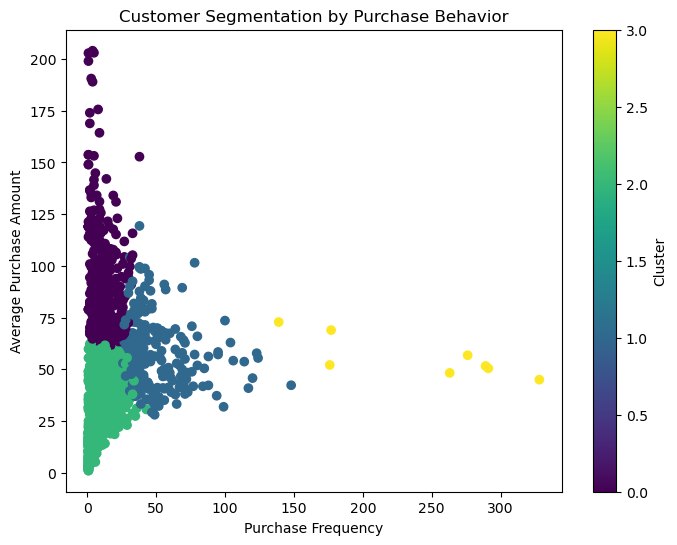

             구매빈도평균   평균구매금액평균       총구매금액평균
Cluster                                     
0         11.403226  90.024296   1480.561102
1         48.019841  57.379435   5208.676667
2          9.986842  33.856329    831.143230
3        242.375000  55.769785  25804.276250


In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 고객 특성 데이터 스케일링
scaler = StandardScaler()
customer_purchase_scaled = scaler.fit_transform(customer_purchase[['구매빈도', '평균구매금액', '총구매금액']])

# KMeans 클러스터링 (클러스터 수는 4개로 가정)
kmeans = KMeans(n_clusters=4, random_state=42)
customer_purchase['Cluster'] = kmeans.fit_predict(customer_purchase_scaled)

# 클러스터 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(customer_purchase['구매빈도'], customer_purchase['평균구매금액'], c=customer_purchase['Cluster'], cmap='viridis')
plt.title('Customer Segmentation by Purchase Behavior')
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Purchase Amount')
plt.colorbar(label='Cluster')
plt.show()

# 클러스터별 평균 구매 행동
cluster_summary = customer_purchase.groupby('Cluster').agg(
    구매빈도평균=('구매빈도', 'mean'),
    평균구매금액평균=('평균구매금액', 'mean'),
    총구매금액평균=('총구매금액', 'mean')
)
print(cluster_summary)


<p>클러스터 특징:<br/>
	•	보라색(Cluster 0): 구매 빈도가 매우 낮고 평균 구매 금액이 높지 않은 고객들로, 아마도 소극적인 구매자일 가능성이 높습니다.<br/>
	•	파란색(Cluster 1): 구매 빈도와 평균 구매 금액이 중간 수준으로, 일반적인 구매 패턴을 보이는 고객군입니다.<br/>
	•	녹색(Cluster 2): 구매 빈도가 낮고 평균 구매 금액도 낮은 고객들로, 저활성 고객에 해당합니다.<br/>
	•	노란색(Cluster 3): 구매 빈도는 높지만 평균 구매 금액은 중간 혹은 낮은 고객들로, 반복 구매를 자주 하지만 개별 구매 금액이 적은 고객군일 가능성이 큽니다.<br/>
<br/>
추가 분석 제안:<br/>
	•	비즈니스 인사이트:<br/>
	•	Cluster 0(보라색): VIP 고객으로 볼 수 있을지 확인. 이들에게 추가적인 혜택을 제공하거나 특별한 캠페인을 통해 유지할 가치가 있을 수 있습니다.<br/>
	•	Cluster 2(녹색): 이탈 가능성이 높은 고객일 가능성이 있으므로, 이들의 관심을 끌 만한 프로모션 필요.<br/>
	•	Cluster 3(노란색): 충성도가 높은 반복 구매자를 대상으로 구매 단가를 올릴 방법을 고려.<br/>
</p>

<h1>특정 카테고리를 구매한 고객에게 관련 상품 추천</h1>

In [3]:
# 고객별 주 구매 카테고리 추출
top_category_per_customer = top_categories[['고객ID', '제품카테고리']].drop_duplicates()

# 특정 카테고리 구매가 많은 고객 추출
category_recommendation = top_category_per_customer.groupby('제품카테고리')['고객ID'].apply(list).reset_index()
category_recommendation.columns = ['제품카테고리', '추천고객목록']

# 추천 카테고리별 고객 확인
print(category_recommendation)


                  제품카테고리                                             추천고객목록
0            Accessories                                        [USER_0615]
1                Apparel  [USER_0000, USER_0003, USER_0004, USER_0005, U...
2                   Bags  [USER_0082, USER_0182, USER_0185, USER_0225, U...
3              Drinkware  [USER_0138, USER_0302, USER_0310, USER_0311, U...
4               Headgear       [USER_0048, USER_0186, USER_0298, USER_0633]
5              Lifestyle  [USER_0053, USER_0070, USER_0134, USER_0157, U...
6                   Nest  [USER_0017, USER_0037, USER_0069, USER_0086, U...
7            Nest-Canada                             [USER_0361, USER_1320]
8               Nest-USA  [USER_0001, USER_0020, USER_0021, USER_0025, U...
9   Notebooks & Journals                  [USER_0051, USER_0093, USER_0173]
10                Office  [USER_0002, USER_0027, USER_0135, USER_0142, U...
11                  Waze                  [USER_0505, USER_0564, USER_0715]
